In [1]:
import Pkg

Pkg.activate(@__DIR__)

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [2]:
using Revise
using JuMP
using ToQUBO                 #px/indicator
using DisjunctiveProgramming #master
using DisjunctiveToQUBO
using QUBOTools
using LinearAlgebra
using HiGHS
using DWave

In [3]:
includet("reactors.jl")

In [4]:
# Set parameters
cx = [1.5, 1]
cy = [6.1, 5.9]
α  = [0.75, 0.8]
d  = 3 # not specified in the problem, I think it is 3

3

$$
\begin{array}{rll}
    \displaystyle \min_{\mathbf{x}, \mathbf{Y}} & \mathbf{c_{x}}'\mathbf{x} + \mathbf{c_{y}}'\mathbf{y} \\
    \textrm{s.t.} & \mathbf{\alpha}'\mathbf{x} \ge d \\[0.75em]
                  & \displaystyle%
                    \bigvee_{i = 1}^{2} \left[\begin{array}{c} Y_{i} \\ x_{i} \leq 0 \end{array}\right] \\[1.75em]
                  & 0 \leq x_{i} \leq 5 & \forall i \\
                  & Y_{i} \iff y_{i} = 1 & \forall i \\
                  & Y_{i} \in \{\textrm{True}, \textrm{False}\} & \forall i \\
                  & y_{i} \in \{0, 1\} & \forall i \\[1em]
   \textrm{data}  & \mathbf{c_{x}} = [1.5, 1] \\
                  & \mathbf{c_{y}} = [6.1, 5.9] \\
                  & \mathbf{\alpha} = [0.75, 8] \\
                  & d = 3
\end{array}
$$

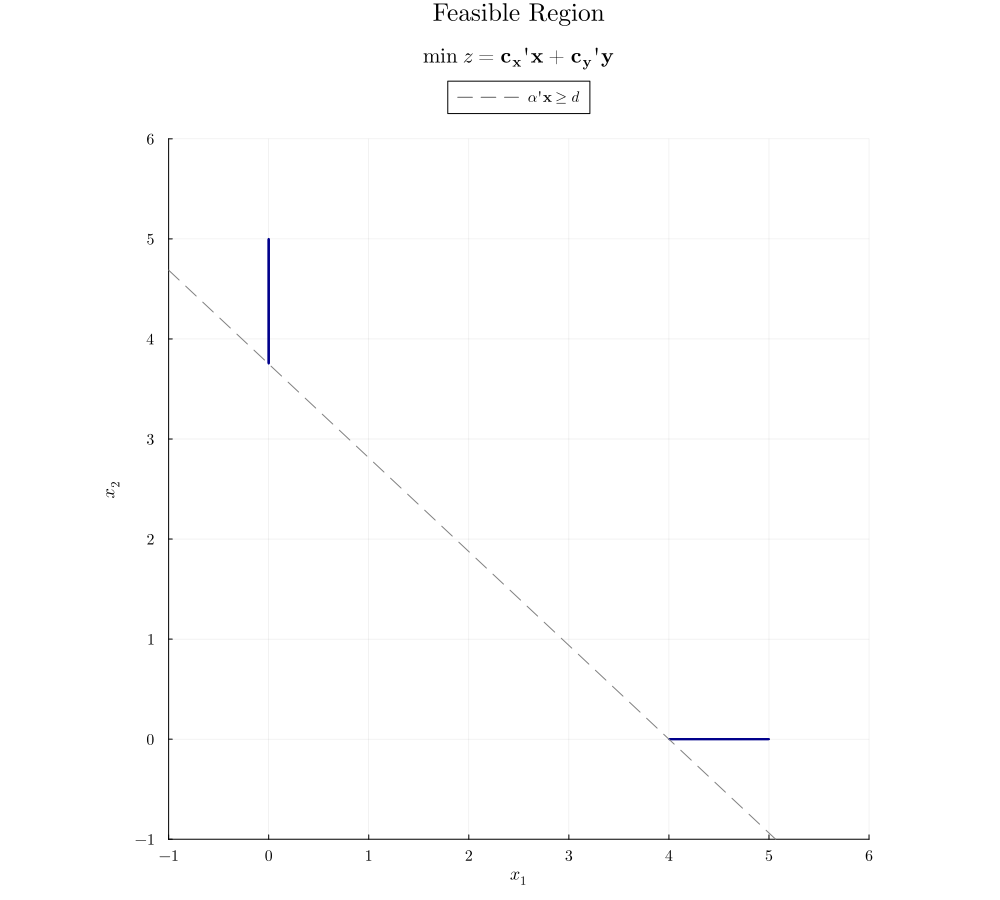

In [5]:
plot_reactor_feasible()

## Optimal Solution

In [25]:
x⃰, z⃰ = let model = solve_gdp_reactors(HiGHS.Optimizer; method=BigM(5.0, false)) do m
        set_silent(m)
    end
    
    value.(model[:x]), objective_value(model)
end

([0.0, 3.75], 9.65)

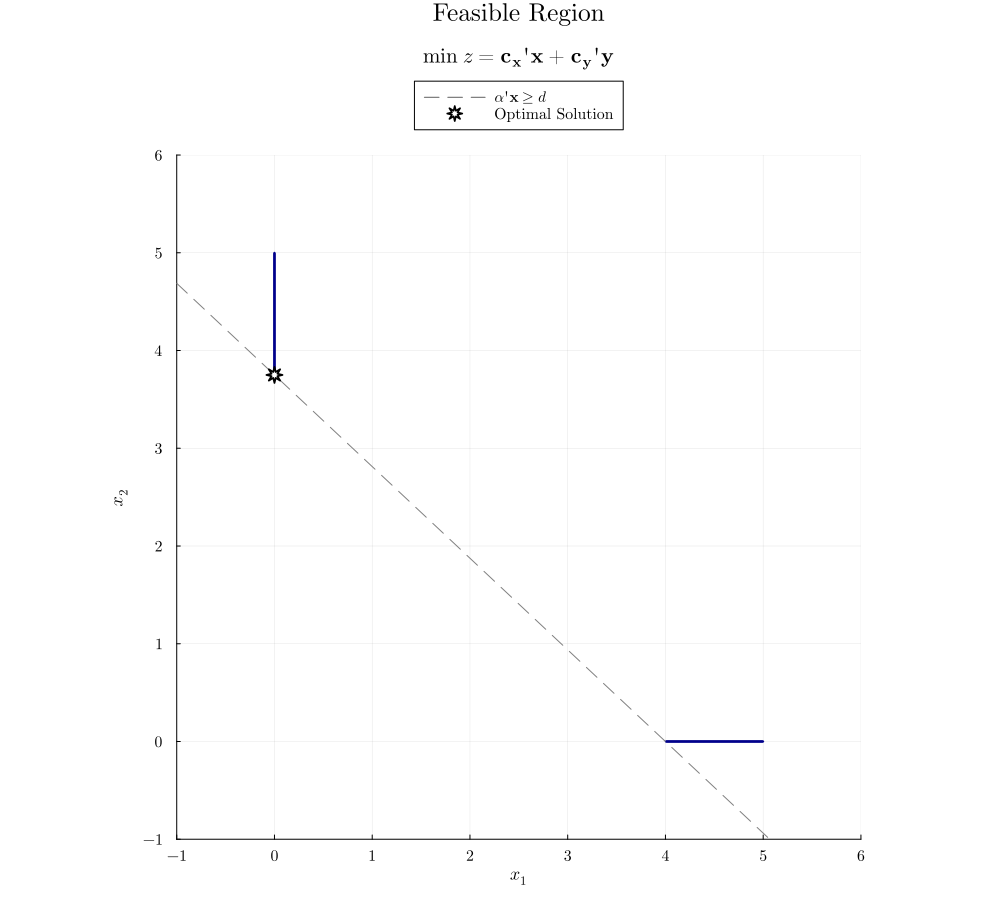

In [26]:
plot_reactor_optimal(x⃰)

## Big-$M$ Reformulation

In [27]:
M = 5.0

bigm_model = solve_gdp_reactors(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = BigM(M, false)
) do m
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(bigm_model)
solution_summary(bigm_model)
sampling_summary(bigm_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 23
  Encoding ………………… 10
  Slack ………………………… 13
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.5928853754940712

⋄ Coefficient Range
  Lower Bound ………… -32817.25
  Upper Bound ………… 104448.0

⋄ Constant Offset: 59593.5

⋄ Work counters
  Compiltaion Time (sec) : 0.000501198

⋄ Sampling Summary

⋄ Number of samples: 796

⋄ Best energy: 9.650000000001455

⋄ Time-to-target (sec): -Inf



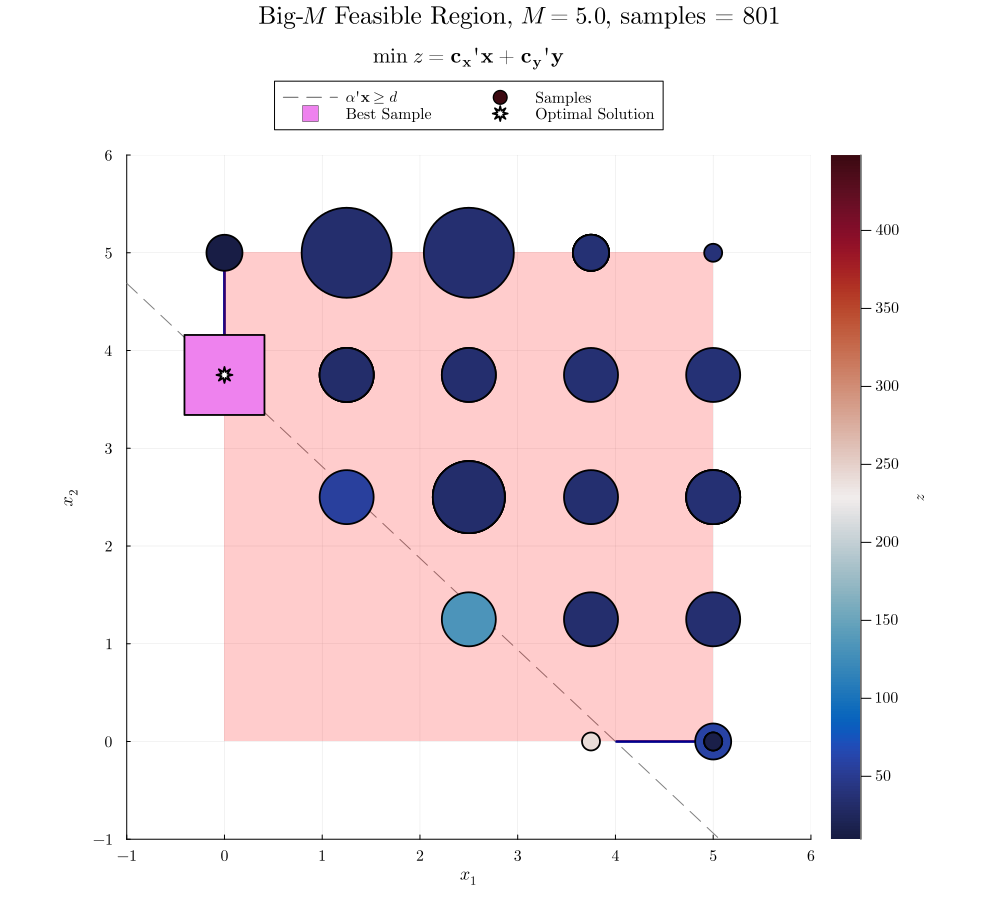

In [11]:
plot_reactor_bigm(bigm_model, x⃰, M)

## Hull Reformulation

In [28]:
hull_model = solve_gdp_reactors(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Hull()
) do m
    set_attribute(m, "num_reads", 10_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(hull_model)
solution_summary(hull_model)
sampling_summary(hull_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 53
  Encoding ………………… 22
  Slack ………………………… 31
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.22060957910014514

⋄ Coefficient Range
  Lower Bound ………… -31389.25
  Upper Bound ………… 104448.0

⋄ Constant Offset: 58777.5

⋄ Work counters
  Compiltaion Time (sec) : 0.000524912

⋄ Sampling Summary

⋄ Number of samples: 8126

⋄ Best energy: 35.14999999999418

⋄ Time-to-target (sec): -Inf



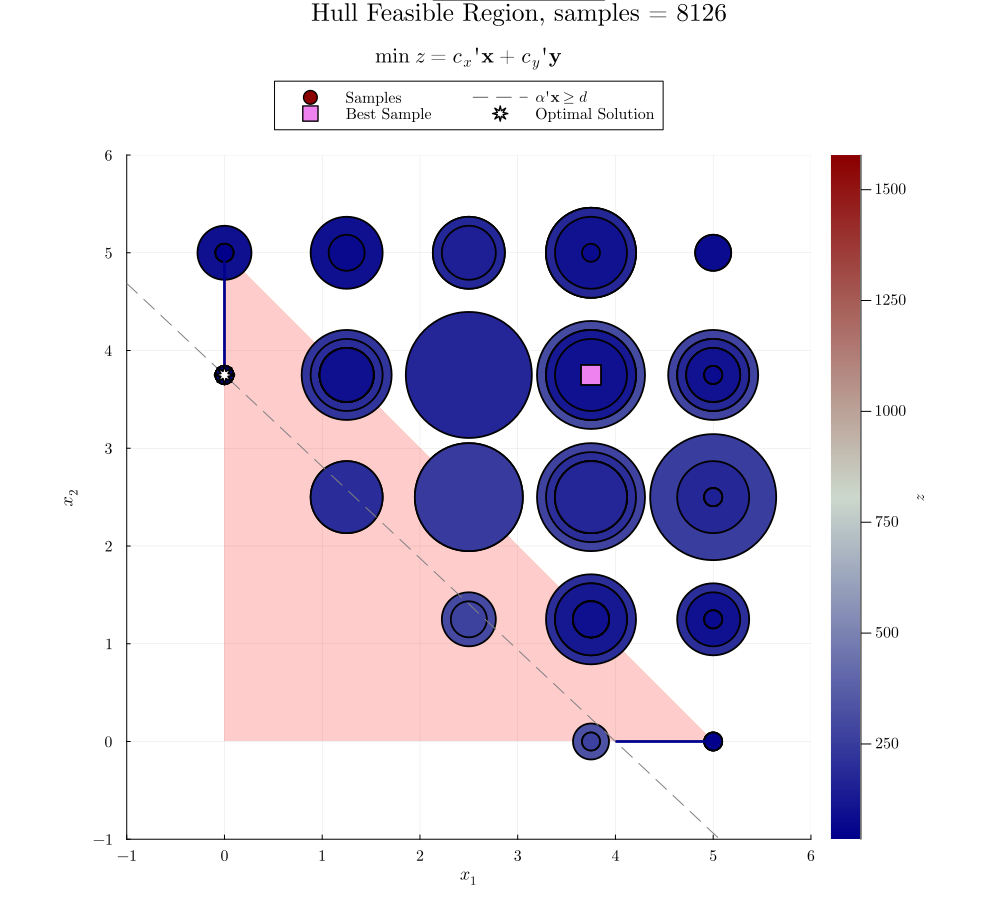

In [30]:
plot_reactor_hull(hull_model, x⃰)

## Indicator Refoormulation

In [29]:
ind_model = solve_gdp_reactors(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Indicator()
) do m
    set_attribute(m, "num_reads", 2_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(ind_model)
solution_summary(ind_model)
sampling_summary(ind_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 29
  Encoding ………………… 10
  Slack ………………………… 7
  Quadratization … 12

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.3694581280788177

⋄ Coefficient Range
  Lower Bound ………… -32638.75
  Upper Bound ………… 104448.0

⋄ Constant Offset: 58777.5

⋄ Work counters
  Compiltaion Time (sec) : 0.000415587

⋄ Sampling Summary

⋄ Number of samples: 1638

⋄ Best energy: 9.650000000001455

⋄ Time-to-target (sec): -Inf



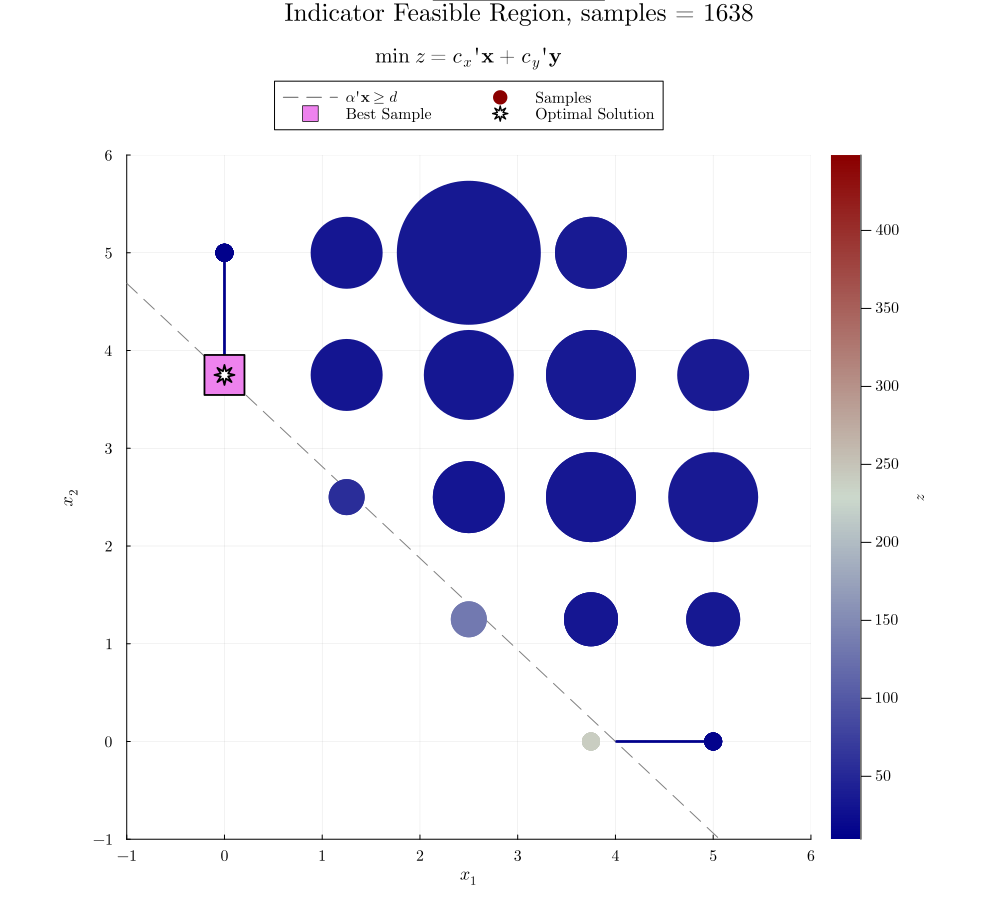

In [31]:
plot_reactor_indicator(ind_model, x⃰)

## Indicator-Interval Reformulation

In [59]:
struct DisjunctEncoding{T} <: ToQUBO.Encoding.VariableEncodingMethod end

DisjunctEncoding() = DisjunctEncoding{Float64}()

ToQUBO.PBO.varshow(v::ToQUBO.VI) = ToQUBO.PBO.varshow(v.value)

In [74]:
function solve_indint_squares()
    model = Model(() -> ToQUBO.Optimizer(DWave.Neal.Optimizer))

    @variable(model, 0 <= x[1:2] <= 5)
    @variable(model, y[1:2], Bin)

    @objective(model, Min, cx'x + cy'y)
    
    @constraint(model, α'x ≥ d)
    
    @constraint(model, sum(y) == 1)
    # @constraint(model, y[1] => {x[2] ≤ 0.0})
    # @constraint(model, y[2] => {x[1] ≤ 0.0})


    set_attribute.(x, ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(x, ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())

    set_attribute(model, "num_reads", 2_000)
    set_attribute(model, "num_sweeps", 2_000)

    let virtual_model = unsafe_backend(model)::ToQUBO.Optimizer
        virtual_model.compiler_settings[:setup_callback] = m -> begin
            @info "Calling setup callback"
            y1 = only(ToQUBO.Encoding.encode!(m, y[1].index, ToQUBO.Encoding.Mirror()).y)
            y2 = only(ToQUBO.Encoding.encode!(m, y[2].index, ToQUBO.Encoding.Mirror()).y)

            let x1 = x[1].index
                z1, ξ, _ = ToQUBO.Encoding.encode(ToQUBO.Encoding.Unary(), (0.0, 5.0), 4) do (nv::Union{Integer,Nothing} = nothing)
                    if isnothing(nv)
                        return MOI.add_variable(m.target_model)
                    else
                        return MOI.add_variables(m.target_model, nv)
                    end
                end

                ξ1 = ToQUBO.PBO.PBF{ToQUBO.VI,Float64}(y2) * ξ
                v1 = ToQUBO.Virtual.Variable{Float64}(
                    DisjunctEncoding(), # new encoding method
                    x1,
                    z1,
                    ξ1,
                    nothing,
                )

                ToQUBO.Encoding.encode!(m, v1)
            end

            let x2 = x[2].index
                z2, ξ, _ = ToQUBO.Encoding.encode(ToQUBO.Encoding.Unary(), (0.0, 5.0), 4) do (nv::Union{Integer,Nothing} = nothing)
                    if isnothing(nv)
                        return MOI.add_variable(m.target_model)
                    else
                        return MOI.add_variables(m.target_model, nv)
                    end
                end

                ξ2 = ToQUBO.PBO.PBF{ToQUBO.VI,Float64}(y1) * ξ
                v2 = ToQUBO.Virtual.Variable{Float64}(
                    DisjunctEncoding(), # new encoding method
                    x2,
                    z2,
                    ξ2,
                    nothing,
                )

                ToQUBO.Encoding.encode!(m, v2)
            end
        end
    end

    set_attribute(model, ToQUBO.Attributes.Quadratize(), true)

    optimize!(model)

    return model
end

indint_model  = solve_indint_squares()
virtual_model = unsafe_backend(indint_model)

compilation_summary(indint_model)
solution_summary(indint_model)
sampling_summary(indint_model, z⃰)

┌ Info: Calling setup callback
└ @ Main /home/pedroxavier/gits/DisjunctiveToQUBO.jl/notebooks/reactors.ipynb:24


⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 117
  Encoding ………………… 10
  Slack ………………………… 7
  Quadratization … 100

⋄ Density
  Linear ……………………… 0.9316239316239316
  Quadratic ……………… 0.05511346890657236

⋄ Coefficient Range
  Lower Bound ………… -32638.75
  Upper Bound ………… 104448.0

⋄ Constant Offset: 58777.5

⋄ Work counters
  Compiltaion Time (sec) : 0.263966609

⋄ Sampling Summary

⋄ Number of samples: 2000

⋄ Best energy: 38.90000000002328

⋄ Time-to-target (sec): -Inf



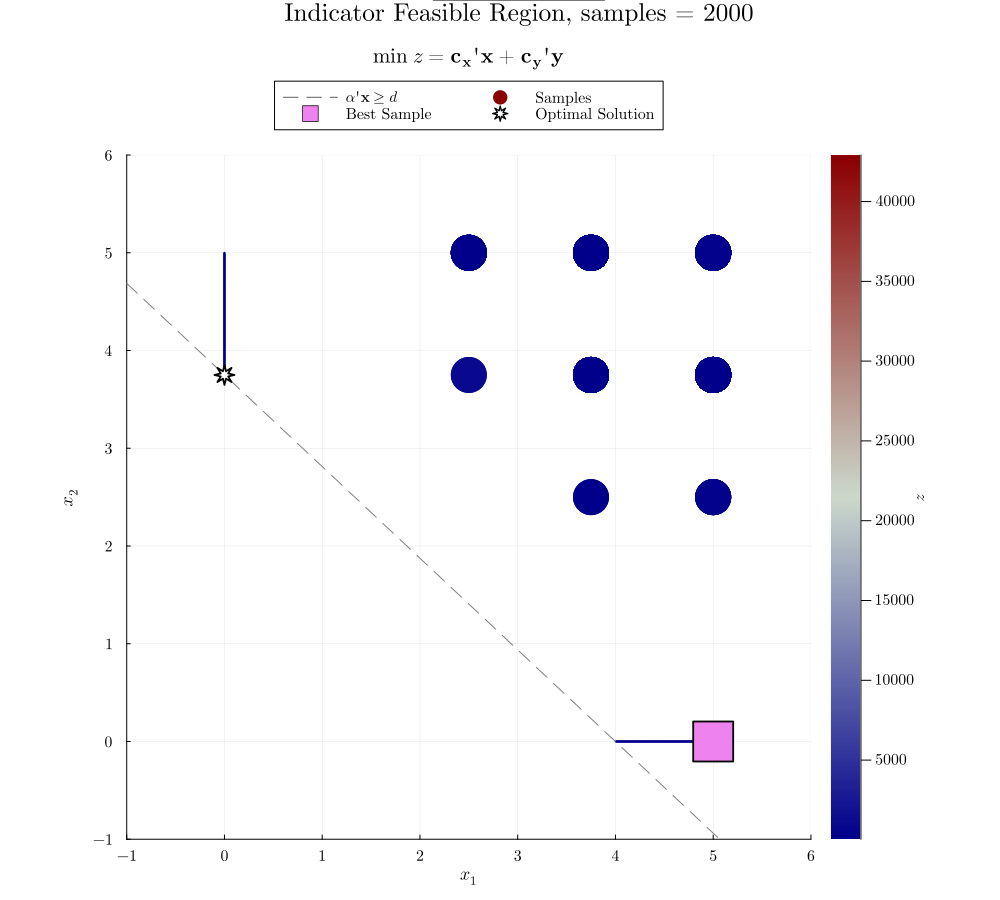

In [77]:
plot_reactor_indicator(indint_model, x⃰)